In [1]:
pip install astropy scipy matplotlib numpy h5py tqdm numba pint-pulsar emcee corner statsmodels pyfftw tbb

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pytest pytest-astropy jinja2 docutils sphinx-astropy nbsphinx pandoc ipython jupyter notebook towncrier tox black

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install stingray PyROA emcee tabulate corner astropy 

Note: you may need to restart the kernel to use updated packages.


In [4]:
%cd /home/jovyan/AS4013/PYCCF

/home/jovyan/AS4013/PYCCF


In [5]:
import shutil

# Replace '/path/to/work_directory' with your actual work directory
work_directory = '/home/jovyan/AS4013'

# Copy xcorspc.so and PYCCF.py to the work directory
shutil.copy('xcorspc.pyx', work_directory)
shutil.copy('PYCCF.py', work_directory)

'/home/jovyan/AS4013/PYCCF.py'

In [6]:
import numpy as np
from stingray import Lightcurve, Crossspectrum, AveragedCrossspectrum
import sys
import argparse
import PYCCF as myccf
import random
from scipy import stats 
import os
import PyROA
import matplotlib.pyplot as plt

/opt/conda/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [7]:
#import AGN light curve
directory_path = '/home/jovyan/AS4013'
file_name = 'lc30mins.dat'
file_path = os.path.join(directory_path, file_name)

column_index1 = 0  
column_index2 = 1

with open(file_path, 'r') as file:
    # Read all lines
    lines = file.readlines()
    data_lines = lines[1:]
    
   # Extract the desired columns from each line and convert to float
    column1_data = [float(line.split()[column_index1]) for line in data_lines]
    column2_data = [float(line.split()[column_index2]) for line in data_lines]

time = np.array(column1_data)/(24*3600)
flux = np.array(column2_data)

In [8]:
cs_binning = 100 #averaged cross spectrum binning 
error_in_flux = 0.01 #define percentage error in flux 
SN = 100 #sound to noise ratio 
samplng_rate = 1 #how many samples are taken per day 
sampling_loss = 0.2 # the amount of data lost due to sampling issues
final_length = 350 #length of final array in days 
dt = 1800 #each interval in seconds 
S = 1.0 # sd of BLR function
M = np.log(13.9) #mean of BLR function 

exposure = len(time) #length of full array 
seconds_day = 86400 #second in a day
original_length = exposure/(seconds_day/dt)

times = (np.linspace(-exposure, exposure+1, num = exposure*2)*dt)/(24*3600) # time array converted to days

## Plot Response function for different BLR fractions  

/tmp/ipykernel_1358/29218394.py:30: RuntimeWarning: divide by zero encountered in divide
  return A2/(S*np.sqrt(2*np.pi*times))*np.exp(-(np.log(times)-M)**2/(2*(S**2)))
/tmp/ipykernel_1358/29218394.py:30: RuntimeWarning: divide by zero encountered in log
  return A2/(S*np.sqrt(2*np.pi*times))*np.exp(-(np.log(times)-M)**2/(2*(S**2)))
/tmp/ipykernel_1358/29218394.py:30: RuntimeWarning: invalid value encountered in multiply
  return A2/(S*np.sqrt(2*np.pi*times))*np.exp(-(np.log(times)-M)**2/(2*(S**2)))


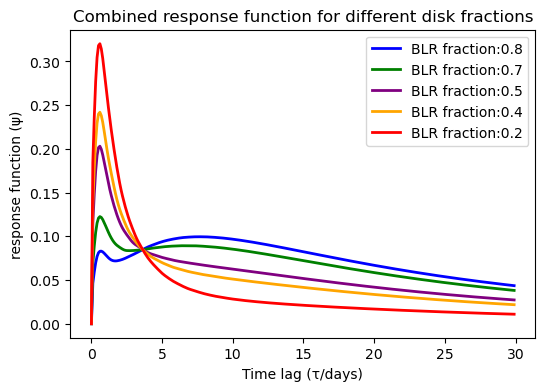

In [10]:

import psi
from scipy.integrate import simps

import importlib
importlib.reload(psi)

bhmass = 10**7.7       # Blakc Hole mass Msol
mdot = 0.5         #  Accretion rate Msol/yr
inc = 45           # inclination, degrees
A1 = [0.2,0.3,0.5,0.6,0.8] #BLR fractions 
color = ['b', 'g', 'purple', 'orange', 'r', 'pink', 'brown'] 
taus = np.arange(0,30,0.1) #the range of time delays to investigate over 

fig, ax = plt.subplots(1,1,figsize=(6,4))

for i in range(len(A1)):
    
    A = A1[i]
    A2 = (1-A)#disk fraction
    # disk response function
    combi_psi = psi.pytfb_sub(taus,1e8,mdot,5000,inc,norm=1)
    combi_psi[np.isnan(combi_psi)]=0
    # normalise 
    normi = simps(combi_psi,x=taus)
    combi_psi = A*(combi_psi/normi)
    
    #BLR response function
    def BLR_function(times):

        return A2/(S*np.sqrt(2*np.pi*times))*np.exp(-(np.log(times)-M)**2/(2*(S**2)))

    BLR_array = BLR_function(taus)
    BLR_array[np.isnan(BLR_array)]=0
    
    #mixture model 
    signal_BLR_Disk = BLR_array + combi_psi

    ax.plot(taus, signal_BLR_Disk, lw=2, label=f'BLR fraction:{A2 :.1f}', color=color[i])
    
ax.set_ylabel("response function (ψ)")
ax.set_xlabel("Time lag (τ/days)")
plt.title("Combined response function for different disk fractions")
ax.legend()
plt.show()


### Plot accretion disk response for wavelength, BH mass and inclinations

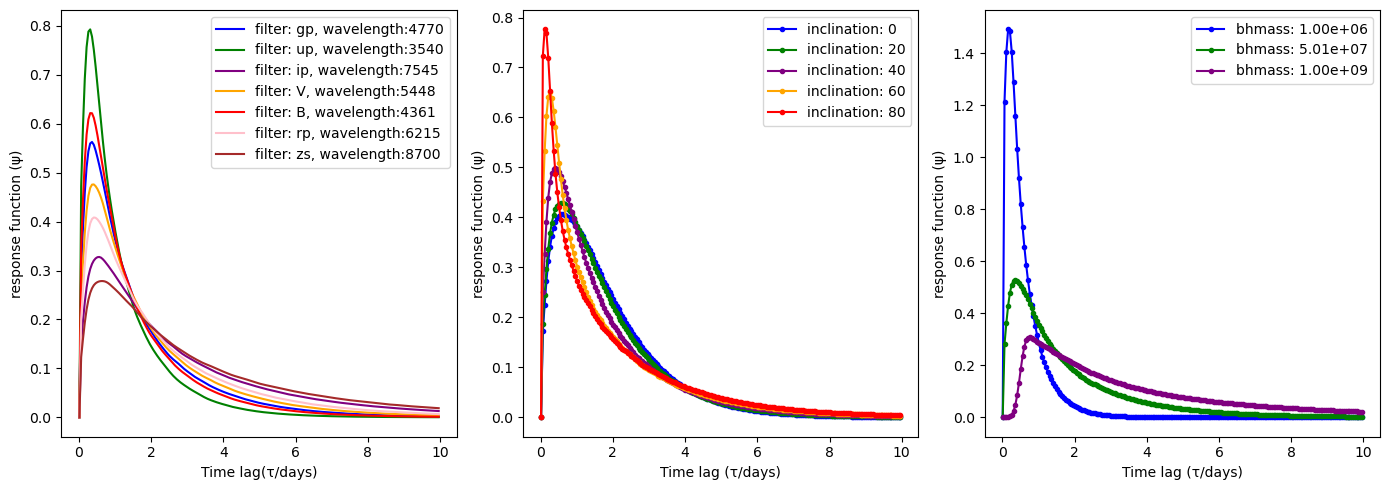

In [11]:
#combi_psi = psi_combi(taus,bhmass,mdot,0,5000,blr_width,blr_radius,inc=inc,component='disc')
import psi
from scipy.integrate import simps

import importlib
importlib.reload(psi)

bhmass = 10**7.7       # Msol
mdot = 0.5         # Msol/yr
inc = 45           # inclination, degrees
#A1 = 0.5
#A2 = (1-A1)
taus = np.arange(.01,10,.05)

#define disk function
def disk(times,wavelength,inc,mdot,bhmass,A1):
    #bhmass = 10**7.7       # Msol
    #mdot = 0.5         # Msol/yr
    #inc = 45           # inclination, degrees
    combi_psi = psi.pytfb_sub(times,bhmass,mdot,wavelength,inc,norm=1)
    combi_psi[np.isnan(combi_psi)]=0
    # normalise 
    normi = simps(combi_psi,x=times)
    return A1*(combi_psi/normi)

# Define BLR function
def BLR(times,A2):

    BLR_array = 1/(S*np.sqrt(2*np.pi*times))*np.exp(-(np.log(times)-M)**2/(2*(S**2)))
    BLR_array[np.isnan(BLR_array)]=0
    return  A2*(BLR_array)


colors = ['b', 'g', 'purple', 'orange', 'r', 'pink', 'brown'] 
lightcurve = ['gp','up', 'ip', 'V', 'B', 'rp', 'zs']
wavelengths = [4770,3540,7545,5448,4361,6215,8700] # range of wavelengths(LCO filters)
bhmass = 10**7.7       # Msol
mdot = 0.5         # Msol/yr
inc = 45           # inclination, degrees

fig, axs = plt.subplots(1, 3, figsize=(14, 5))

for i in range(7):
    
    axs[0].plot(taus,disk(taus,wavelengths[i],inc,mdot,bhmass,1),label=f'filter: {lightcurve[i]}, wavelength:{wavelengths[i]}',color=colors[i])
axs[0].set_xlabel("Time lag(τ/days)")
axs[0].set_ylabel("response function (ψ)")
axs[0].legend()

inclination = [0,20,40,60,80]#range of inclinations
bhmass = 10**7.7      
mdot = 0.5       

for i in range(len(inclination)):
    
    axs[1].plot(taus,disk(taus,5000,inclination[i],mdot,bhmass,1),label=f'inclination: {inclination[i]}',marker='.',color=colors[i])
axs[1].set_xlabel("Time lag (τ/days)")
axs[1].set_ylabel("response function (ψ)")
axs[1].legend()

inc = 45
bhmass = [10**6,10**7.7,10**9] # range o       
mdot = 0.5        

for i in range(len(bhmass)):
    scientific_notation = "{:.2e}".format(bhmass[i]) 
    axs[2].plot(taus,disk(taus,5000,inc,mdot,bhmass[i],1),label=f'bhmass: {scientific_notation}',marker='.',color=colors[i])
axs[2].set_ylabel("response function (ψ)")
axs[2].set_xlabel("Time lag (τ/days)")
axs[2].legend()

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.tight_layout()
plt.show()


In [12]:
bhmass = 10**7.7       # Msol
mdot = 0.5         # Msol/yr
inc = 45           # inclination, degrees
#A1 = 0.5
#A2 = (1-A1)
taus = np.arange(.01,10,.05)

def disk(times,wavelength,inc,mdot,bhmass,A1):
    #bhmass = 10**7.7       # Msol
    #mdot = 0.5         # Msol/yr
    #inc = 45           # inclination, degrees
    combi_psi = psi.pytfb_sub(times,bhmass,mdot,wavelength,inc,norm=1)
    combi_psi[np.isnan(combi_psi)]=0
    # normalise 
    normi = simps(combi_psi,x=times)
    return A1*(combi_psi/normi)

# Define BLR function
def BLR(times,A2):

    BLR_array = 1/(S*np.sqrt(2*np.pi*times))*np.exp(-(np.log(times)-M)**2/(2*(S**2)))
    BLR_array[np.isnan(BLR_array)]=0
    return  A2*(BLR_array)



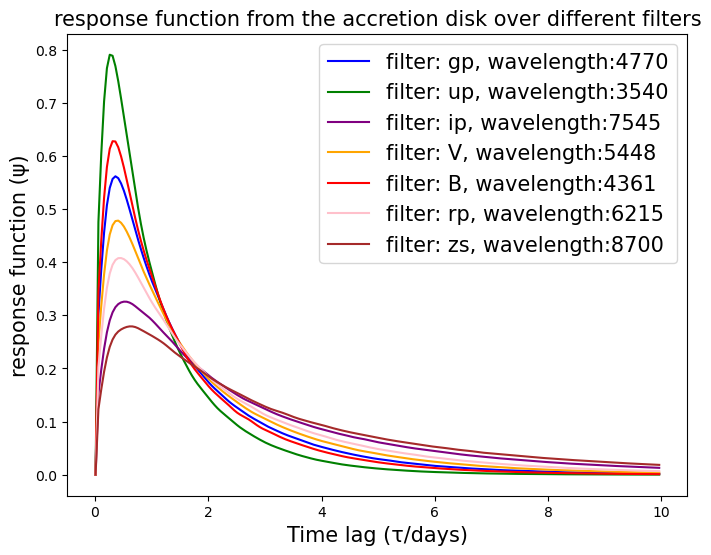

In [13]:
colors = ['b', 'g', 'purple', 'orange', 'r', 'pink', 'brown'] 
lightcurve = ['gp','up', 'ip', 'V', 'B', 'rp', 'zs']
wavelengths = [4770,3540,7545,5448,4361,6215,8700]
bhmass = 10**7.7       # Msol
mdot = 0.5         # Msol/yr
inc = 45           # inclination, degrees

fig, ax = plt.subplots(1,1,figsize=(8,6))
for i in range(7):
    
    ax.plot(taus,disk(taus,wavelengths[i],inc,mdot,bhmass,1),label=f'filter: {lightcurve[i]}, wavelength:{wavelengths[i]}',color=colors[i])
ax.set_ylabel("response function (ψ)",fontsize=15)
ax.set_xlabel("Time lag (τ/days)",fontsize=15)
plt.title("response function from the accretion disk over different filters",fontsize=15)
plt.savefig('/home/jovyan/AS4013/response_filter.png')
ax.legend(fontsize=15)


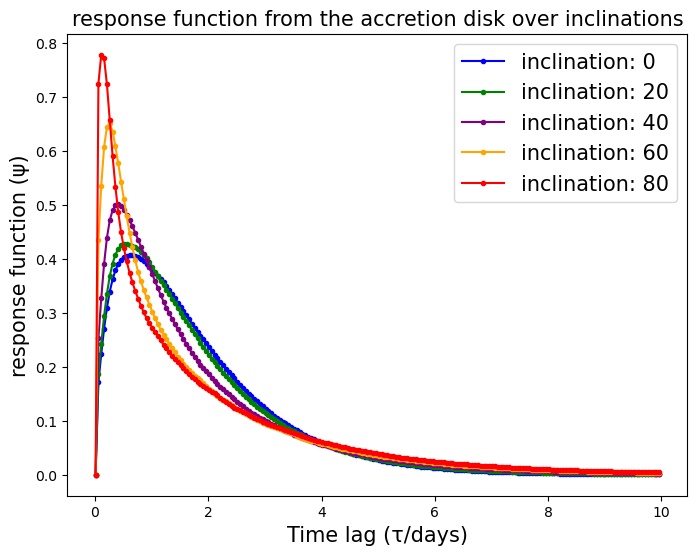

In [14]:
colors = ['b', 'g', 'purple', 'orange', 'r', 'pink', 'brown', 'black','yellow'] 
inclination = [0,20,40,60,80]
bhmass = 10**7.7       # Msol
mdot = 0.5         # Msol/yr
           # inclination, degrees

fig, ax = plt.subplots(1,1,figsize=(8,6))
for i in range(len(inclination)):
    
    ax.plot(taus,disk(taus,5000,inclination[i],mdot,bhmass,1),label=f'inclination: {inclination[i]}',marker='.',color=colors[i])
ax.set_ylabel("response function (ψ)",fontsize=15)
ax.set_xlabel("Time lag (τ/days)",fontsize=15)
plt.title("response function from the accretion disk over inclinations",fontsize=15)
plt.savefig('/home/jovyan/AS4013/response_inc.png')
ax.legend(fontsize=15)


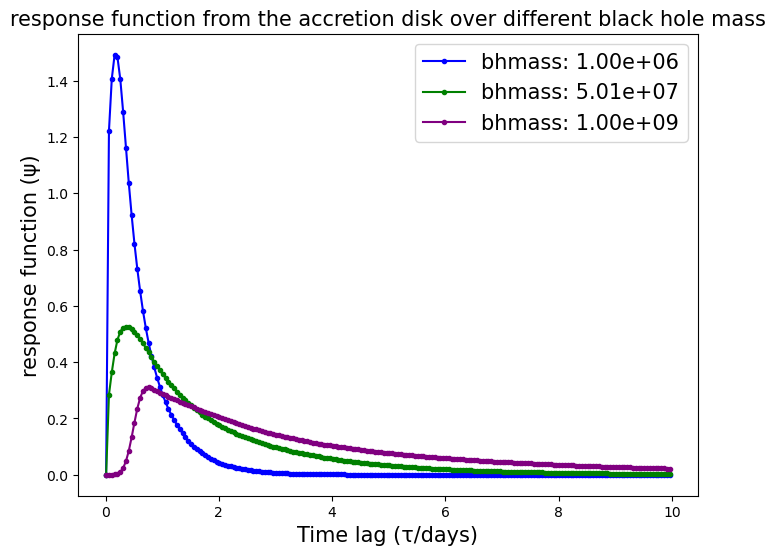

In [15]:
colors = ['b', 'g', 'purple', 'orange', 'r', 'pink', 'brown', 'black','yellow'] 
inc = 45
bhmass = [10**6,10**7.7,10**9]       # Msol
mdot = 0.5         # Msol/yr
           # inclination, degrees

fig, ax = plt.subplots(1,1,figsize=(8,6))
for i in range(len(bhmass)):
    scientific_notation = "{:.2e}".format(bhmass[i]) 
    ax.plot(taus,disk(taus,5000,inc,mdot,bhmass[i],1),label=f'bhmass: {scientific_notation}',marker='.',color=colors[i])
ax.set_ylabel("response function (ψ)",fontsize=15)
ax.set_xlabel("Time lag (τ/days)",fontsize=15)
plt.title("response function from the accretion disk over different black hole mass",fontsize=15)
plt.savefig('/home/jovyan/AS4013/response_bhmass.png')

ax.legend(fontsize=15)
